In [1]:
from IPython.display import clear_output

In [2]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-geometric==2.3.1
# !pip install torch-geometric-temporal
# clear_output()

In [3]:
import os
import pickle

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

In [4]:
def load_features(feat_path, dtype=np.float32):
    feat_df = np.load(feat_path).transpose(2, 1, 0)
    feat = np.array(feat_df, dtype=dtype)
    return feat


def load_adjacency_matrix(adj_path, dtype=np.float32):
    adj_df = pd.read_csv(adj_path, header=None)
    adj = np.array(adj_df, dtype=dtype)
    return adj

In [5]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
# feat_path = f"{data_path}/speed.csv"
# adj_path = f"{data_path}/adj.csv"

# Для данных microservices
adj_type = "bad"
service = "no"
type_data = "calls"
feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)
model_type = "a3tgcn"

seq_len = 12
pre_len = 3
node_features = feat.shape[1]
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE=64

In [6]:
def train_test_split(data, split_ratio=0.8):
    data_len = data.shape[0]
    train_size = int(data_len * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def xy_split(data: np.ndarray, seq_len: int = 12, pre_len: int = 3):
    X_data, Y_data = [], []
    
    for i in range(data.shape[0] - int(seq_len + pre_len - 1)):
        a = data[i:i + seq_len + pre_len]
        X_data.append(a[:seq_len])
        Y_data.append(a[seq_len:seq_len + pre_len, 0])

    return np.array(X_data).transpose((0, 3, 2, 1)), np.array(Y_data).transpose((0, 2, 1))


def normalize_data(data: np.ndarray, means: np.ndarray, stds: np.ndarray):
    normalized_data = (data - means) / stds
    return np.nan_to_num(normalized_data, 0)


def denormalize_data(normalized_data: np.ndarray, means: np.ndarray, stds: np.ndarray):
    return normalized_data * stds + means        

In [7]:
# train_data, test_data = train_test_split(data=feat)
# means = train_data.mean(axis=0)
# stds = train_data.std(axis=0)

# train_data_normalized = normalize_data(train_data, means, stds)
# test_data_normalized = normalize_data(test_data, means, stds)

# X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
# X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)

### Подготовка матрицы смежности

In [8]:
def get_edge_parameters(adj_matrix):
    edges = np.nonzero(adj_matrix)
    edges = np.vstack([edges, adj_matrix[edges]])
    edge_index = edges[:2, :].astype(float)
    edge_attr = edges[2, :].astype(float)
    
    return edge_index, edge_attr

In [9]:
def get_data_loaders(data: np.ndarray, adj_matrix: np.ndarray, seq_len: int, pre_len: int):
    train_data, test_data = train_test_split(data=data)
    means = train_data.mean(axis=0)
    stds = train_data.std(axis=0)
    
    train_data_normalized = normalize_data(train_data, means, stds)
    test_data_normalized = normalize_data(test_data, means, stds)

    X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
    X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)
    
    edge_index, edge_attr = get_edge_parameters(adj_matrix)
    
    shuffle=False

    train_x_tensor = torch.from_numpy(X_train).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(Y_train).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=BATCH_SIZE, shuffle=shuffle)
    
    test_x_tensor = torch.from_numpy(X_test).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(Y_test).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=BATCH_SIZE, shuffle=shuffle)

    train_dataset = StaticGraphTemporalSignal(edge_index, edge_attr, X_train, Y_train)
    test_dataset = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
    
    return train_loader, test_loader, train_dataset, test_dataset
    

## A3TGCN

In [10]:
class A3TGCNModel(torch.nn.Module):
    def __init__(self, seq_len, pre_len, hidden_layers=32):
        super(A3TGCNModel, self).__init__()
        self.recurrent = A3TGCN2(in_channels=node_features, out_channels=hidden_layers, periods=seq_len, batch_size=BATCH_SIZE)
        self.linear = torch.nn.Linear(hidden_layers, pre_len)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [11]:
def evaluate_model(model, data_loader, edge_index, edge_weight):
    loss = 0
    step = 0
    
    with torch.no_grad():
        for encoder_inputs, labels in data_loader:
            y_hat = model(encoder_inputs, edge_index, edge_weight)
            loss = loss + torch.mean(torch.abs(y_hat - labels))
            step += 1
        loss = loss / (step + 1)
    
    print("Val loss MAE: {:.4f}".format(loss.item()))
    return loss.item()

### Обучение модели

In [41]:
def train_model(model, train_loader, test_loader, optimizer, epochs, pre_len, edge_index, edge_weight):
    train_losses, val_losses = [], []
    best_val_loss = np.inf

    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        print('==========')
        if epoch + 1 == 100:
            optimizer.param_groups[0]['lr'] = 0.005

        loss_list = []
        model.train()
        
        for encoder_inputs, labels in train_loader:
            y_hat = model(encoder_inputs, edge_index, edge_weight)
            loss = torch.mean(torch.abs(y_hat - labels))
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss = sum(loss_list)/len(loss_list)
        train_losses.append(loss)
        print("Train loss MAE: {:.4f}".format(loss))

        val_loss = evaluate_model(model, test_loader, edge_index, edge_weight)
        val_losses.append(val_loss)
        
        path_save = f"/kaggle/working/models/{dataset}/{pre_len}/{model_type}"
        # path_save = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"
        if not os.path.exists(path_save):
            os.makedirs(path_save)
        with open(f"{path_save}/losses.pk", "wb") as f:
            pickle.dump((train_losses, val_losses), f)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), f"{path_save}/best_model.pt")
            best_val_loss = val_loss
            print(f"Model with {best_val_loss} was saved.")

    return model, train_losses, val_losses

In [42]:
def main(seq_len, pre_len, model = None):
    device = DEVICE
    train_loader, test_loader, train_dataset, test_dataset = get_data_loaders(feat, adj_matrix, seq_len, pre_len)
    for snapshot in train_dataset:
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)
        break

    if not model:
        model = A3TGCNModel(seq_len, pre_len)
    model.to(device)

    lr = 0.005
    epochs = 100
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model, train_losses, val_losses = train_model(model, train_loader, test_loader, optimizer, epochs, pre_len, edge_index, edge_weight)
    
    return model, train_losses, val_losses
    

In [ ]:
for pre_len in (3, 6, 12):
    model, train_losses, val_losses = main(seq_len=12, pre_len=pre_len)

Epoch:  1
Train loss MAE: 0.3159
Val loss MAE: 0.3698
Model with 0.3697985112667084 was saved.
Epoch:  2
Train loss MAE: 0.2948
Val loss MAE: 0.3824
Epoch:  3
Train loss MAE: 0.2978
Val loss MAE: 0.3915
Epoch:  4
Train loss MAE: 0.3046
Val loss MAE: 0.3738
Epoch:  5
Train loss MAE: 0.3056
Val loss MAE: 0.3346
Model with 0.3345583975315094 was saved.
Epoch:  6
Train loss MAE: 0.2929
Val loss MAE: 0.3251
Model with 0.32505467534065247 was saved.
Epoch:  7
Train loss MAE: 0.2948
Val loss MAE: 0.3244
Model with 0.3244035840034485 was saved.
Epoch:  8
Train loss MAE: 0.2934
Val loss MAE: 0.3228
Model with 0.32275497913360596 was saved.
Epoch:  9
Train loss MAE: 0.2886
Val loss MAE: 0.3216
Model with 0.32155361771583557 was saved.
Epoch:  10
Train loss MAE: 0.2952
Val loss MAE: 0.3335
Epoch:  11
Train loss MAE: 0.2891
Val loss MAE: 0.3199
Model with 0.31986764073371887 was saved.
Epoch:  12
Train loss MAE: 0.2871
Val loss MAE: 0.3178
Model with 0.31784000992774963 was saved.
Epoch:  13
Train

# Генерация данных по предсказаниям

#### metr-la, seoul

In [25]:
dataset = "seoul"
data_path = f"../../data/{dataset}"
feat_path = f"{data_path}/speed.npy"
adj_path = f"{data_path}/adj.csv"
model_type = "a3tgcn"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

seq_len = 12
pre_len = 12

model_path = f"../../models/{dataset}/{pre_len}/{model_type}"

In [16]:
def read_model(model_path: str, seq_len, pre_len):
    model = A3TGCNModel(seq_len=seq_len, pre_len=pre_len)
    model.load_state_dict(torch.load(f"{model_path}/best_model.pt", map_location=torch.device('cpu')))
    return model

In [17]:
def get_predict_result(model, data_loader, edge_index, edge_weight, means, stds):
    model.eval()
    Y_preds = list()

    with torch.no_grad():
        for encoder_inputs, labels in data_loader:
            y_hat = model(encoder_inputs, edge_index, edge_weight).cpu().detach().numpy().tolist()
            
            Y_preds.extend(y_hat)
        Y_preds = denormalize_data(Y_preds, means[0].reshape([-1, 1]), stds[0].reshape([-1, 1]))
    return Y_preds

In [28]:
train_data, test_data = train_test_split(data=feat)
means = feat.mean(axis=0)
stds = feat.std(axis=0)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

train_loader, test_loader, train_dataset, test_dataset = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

for snapshot in train_dataset:
    edge_index = snapshot.edge_index.to(DEVICE)
    edge_weight = snapshot.edge_attr.to(DEVICE)
    break

In [29]:
model = read_model(model_path=model_path, seq_len=seq_len, pre_len=pre_len)
save_path = f"../../result_predict/{dataset}/{pre_len}"

In [30]:
Y_preds = get_predict_result(
    model=model,
    data_loader=train_loader,
    edge_index=edge_index,
    edge_weight=edge_weight,
    means=means,
    stds=stds,
)
np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

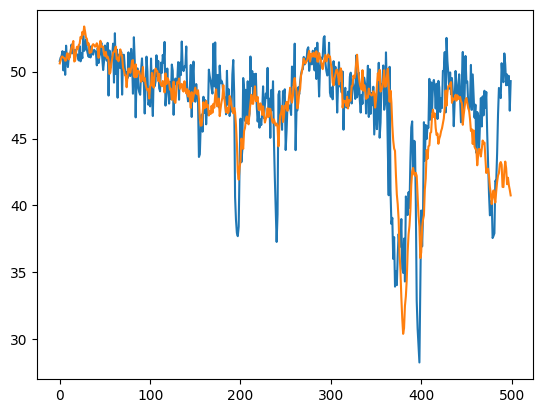

In [31]:
plt.plot(Y_train_ground_truth[0:500, 0, 0])
plt.plot(Y_preds[0:500, 0, 0])

In [32]:
Y_preds = get_predict_result(
    model=model,
    data_loader=test_loader,
    edge_index=edge_index,
    edge_weight=edge_weight,
    means=means,
    stds=stds,
)
np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

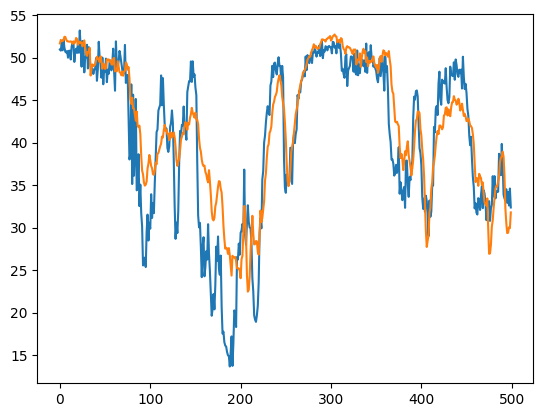

In [33]:
plt.plot(Y_test_ground_truth[0:500, 0, 0])
plt.plot(Y_preds[0:500, 0, 0])

### microservices

default_data

In [18]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
adj_type = "good"
service = "no"
type_data = "calls"
feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

model_type = "a3tgcn"
seq_len = 12
pre_len = 3

model_path = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"

In [24]:
train_data, test_data = train_test_split(data=feat)
means = train_data.mean(axis=0)
stds = train_data.std(axis=0)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

train_loader, test_loader, train_dataset, test_dataset = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

for snapshot in train_dataset:
    edge_index = snapshot.edge_index.to(DEVICE)
    edge_weight = snapshot.edge_attr.to(DEVICE)
    break

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [25]:
def read_model(model_path: str, seq_len, pre_len):
    model = A3TGCNModel(seq_len=seq_len, pre_len=pre_len, hidden_layers=16)
    model.load_state_dict(torch.load(f"{model_path}/best_model.pt", map_location=torch.device('cpu')))
    return model

In [26]:
model = read_model(model_path=model_path, seq_len=seq_len, pre_len=pre_len)
save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}"

In [27]:
Y_preds = get_predict_result(
    model=model,
    data_loader=train_loader,
    edge_index=edge_index,
    edge_weight=edge_weight,
    means=means,
    stds=stds,
)
np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

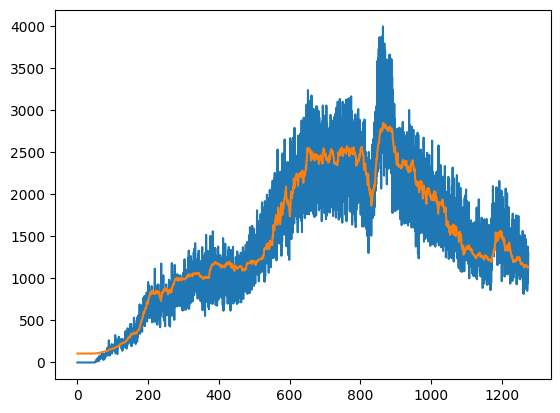

In [28]:
plt.plot(Y_train_ground_truth[:, 1, 0])
plt.plot(Y_preds[:, 1, 0])

In [29]:
Y_preds = get_predict_result(
    model=model,
    data_loader=test_loader,
    edge_index=edge_index,
    edge_weight=edge_weight,
    means=means,
    stds=stds,
)
np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

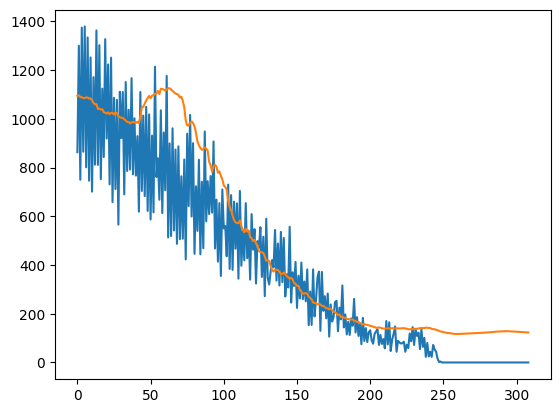

In [30]:
plt.plot(Y_test_ground_truth[:, 1, 0])
plt.plot(Y_preds[:, 1, 0])

fault data

In [32]:
for service in ["cart"]:# "currency", "product"):
    feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
    save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}"
    
    feat = load_features(feat_path)
    _, Y_ground_truth = xy_split(feat, seq_len, pre_len)
    means = feat.mean(axis=0)
    stds = feat.std(axis=0)
    data_normalized = normalize_data(feat, means, stds)
    X_test, Y_test = xy_split(data_normalized, seq_len, pre_len)
    test_x_tensor = torch.from_numpy(X_test).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(Y_test).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset_new)
    Y_preds = get_predict_result(
        model=model,
        data_loader=test_loader,
        edge_index=edge_index,
        edge_weight=edge_weight,
        means=means,
        stds=stds,
    )
    # np.save(f"{save_path}/ground_truth/test.npy", Y_ground_truth)
    np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


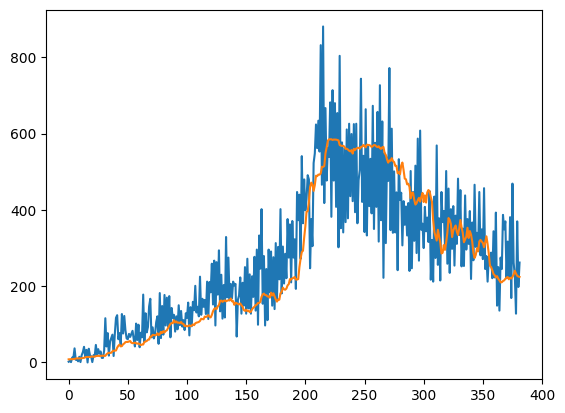

In [34]:
plt.plot(Y_ground_truth[:, 1, 0])
plt.plot(Y_preds[:, 1, 0])